In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2, matplotlib
import KDEpy

from sklearn.decomposition import PCA
from KDEpy.bw_selection import silvermans_rule

In [2]:
def direction(azdeg=90, altdeg=45):
    """ The unit vector direction towards the light source """

    # Azimuth is in degrees clockwise from North. Convert to radians
    # counterclockwise from East (mathematical notation).
    az = np.radians(azdeg)
    alt = np.radians(altdeg)

    return np.array([
        np.cos(az) * np.cos(alt),
        np.sin(az) * np.cos(alt),
        np.sin(alt)
    ])

def calNormal(elevation, vert_exag=1, dx=1, dy=1):
    # compute the normal vectors from the partial derivatives
    e_dy, e_dx = np.gradient(vert_exag * elevation, dy, dx)

    # .view is to keep subclasses
    normal = np.empty(elevation.shape + (3,)).view(type(elevation))
    normal[..., 0] = -e_dx
    normal[..., 1] = -e_dy
    normal[..., 2] = 1
    normal /= np.linalg.norm(normal, axis=2)[..., None]

    return normal

def linear_mapping(x1, x2, y1, y2):
    k = (y1-y2)/(x1-x2)
    b = y1 - k*x1
    return lambda x: k*x+b

def calIntensity(normal, direction, fraction=1.):
    intensity = normal.dot(direction)
    flatIntensity = np.array([0,0,1]).dot(direction)
    return intensity-flatIntensity

def blendLChannel(rgb, intensity):
    # Adjusting lightness according to shading (implemented by OpenCV)
    result = cv2.cvtColor(rgb[:,:,:3].astype(np.float32), cv2.COLOR_RGB2LAB)
    result[:,:,0] = np.clip(result[:,:,0] + intensity, 0, 100)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2RGB)
    return result

def blendMultiplication(rgb, intensity):
    # Adjusting lightness according to shading (implemented by OpenCV)
    result = rgb[:,:,:3]*intensity[...,None]
    result = np.clip(result, 0, 1)
    return result

def setupLightDirection3(filtered_normal):
    normal_xy = filtered_normal[:, :2]
    normal_a = np.mean(normal_xy, axis=0)
    dk = normal_xy-normal_a

    pca = PCA(n_components=2)
    pca.fit(dk) # reduce (w,h,3) to (w*h,3)
    lambda_eigen_v = np.sqrt(pca.explained_variance_[0])*pca.components_[0]
    light_direction = normal_a+lambda_eigen_v
    light_direction2 = normal_a-lambda_eigen_v
    if light_direction[0] < 0:
        light_direction = normal_a-lambda_eigen_v
        light_direction2 = normal_a+lambda_eigen_v

    z_component = np.sin(np.radians(60))
    light_direction/=np.linalg.norm(light_direction)/np.sqrt(1-z_component**2)
    light_direction = np.append(light_direction, z_component)
    light_direction2/=np.linalg.norm(light_direction2)/np.sqrt(1-z_component**2)
    light_direction2 = np.append(light_direction2, z_component)
    return [light_direction, light_direction2]

# teaser

In [3]:
df = pd.read_csv('./datasets/taxis.csv', header=None).dropna()

In [4]:
# compute the structure map by differencing KDE fields with large and small bandwidths
data = df[[0,1]].values
xmin, ymin = data.min(axis=0)
xmax, ymax = data.max(axis=0)
xoffset, yoffset = 0.01*np.array([xmax-xmin, ymax-ymin])
X,Y = np.mgrid[(xmin-xoffset):(xmax+xoffset):450j, (ymin-yoffset):(ymax+yoffset):300j]
grid = np.vstack([X.ravel(), Y.ravel()]).T

bw1 = min(silvermans_rule(data[:, [0]]), silvermans_rule(data[:, [1]]))
data_scaled = data / np.array([bw1])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw1]))
points = points/points.sum()*data.shape[0]
large_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
# bw2 = min([1/X.shape[0], 1/X.shape[1]])
bw2 = 2e-4
data_scaled = data / np.array([bw2])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw2]))
points = points/points.sum()*data.shape[0]
small_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
diff = large_bw_kde - small_bw_kde

In [5]:
# colorize the KDE field with the large bandwidth
dst = large_bw_kde
vmin, vmax = dst.min(), dst.max()
colormap = plt.cm.magma_r
norm = matplotlib.colors.Normalize(vmin, vmax)
rgb = colormap(norm(dst))

In [6]:
# compute the exaggerated intensity field
eta, phi = 5, -25
normal = calNormal(diff, vert_exag=eta)
ld, _ = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

In [7]:
# Luminance-Only Color Composition
intensity = linear_mapping(intensity.min(), np.array([0,0,1]).dot(ld), phi, 0)(intensity)
result = blendLChannel(rgb, intensity)

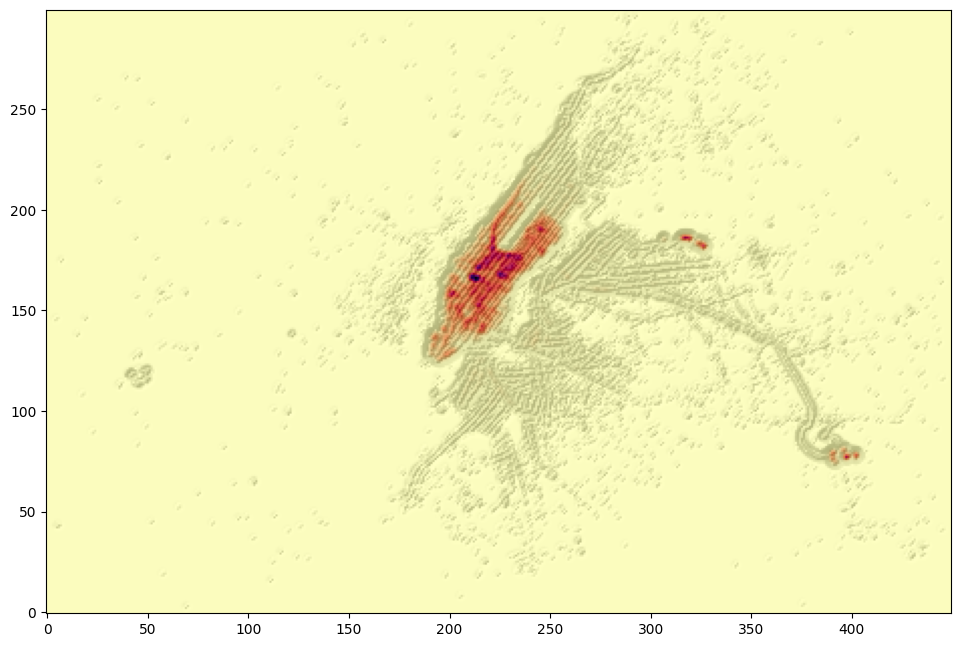

In [8]:
plt.figure(figsize=(9,6), dpi=100)
# plt.imshow(rgb, origin='lower')
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

# Fig. 2: Pipeline

In [9]:
df = pd.read_csv('./datasets/HR_diagram.csv', header=None).dropna()

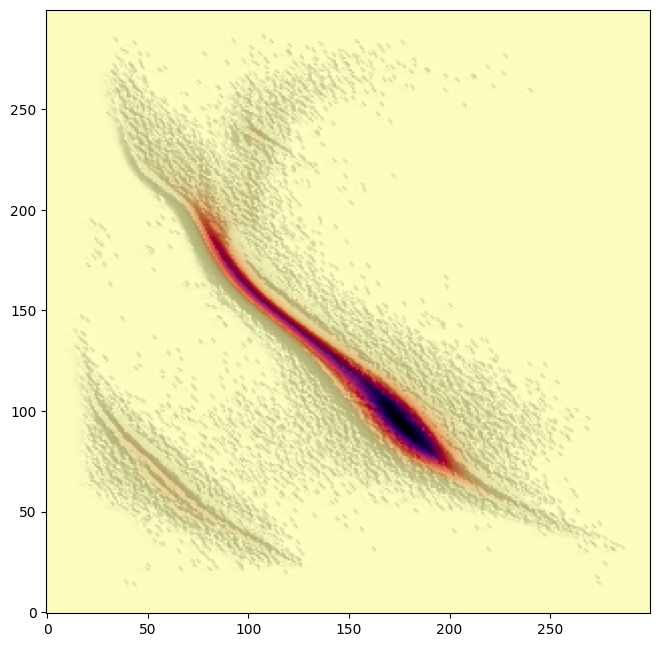

In [10]:
# compute the structure map by differencing KDE fields with large and small bandwidths
data = df[[0,1]].values
xmin, ymin = data.min(axis=0)
xmax, ymax = data.max(axis=0)
xoffset, yoffset = 0.05*np.array([xmax-xmin, ymax-ymin])
X,Y = np.mgrid[(xmin-xoffset):(xmax+xoffset):300j, (ymin-yoffset):(ymax+yoffset):300j]
grid = np.vstack([X.ravel(), Y.ravel()]).T

bw1 = min(silvermans_rule(data[:, [0]]), silvermans_rule(data[:, [1]]))
data_scaled = data / np.array([bw1])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw1]))
points = points/points.sum()*data.shape[0]
large_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
bw2 = min([1/X.shape[0], 1/X.shape[1]])
data_scaled = data / np.array([bw2])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw2]))
points = points/points.sum()*data.shape[0]
small_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
diff = large_bw_kde - small_bw_kde

# colorize the KDE field with the large bandwidth
dst = large_bw_kde
vmin, vmax = dst.min(), dst.max()
colormap = plt.cm.magma_r
norm = matplotlib.colors.Normalize(vmin, vmax)
rgb = colormap(norm(dst))

# compute the exaggerated intensity field
eta, phi = 5, -25
normal = calNormal(diff, vert_exag=eta)
ld,_ = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

# Luminance-Only Color Composition
intensity = linear_mapping(intensity.min(), np.array([0,0,1]).dot(ld), phi, 0)(intensity)
result = blendLChannel(rgb, intensity)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

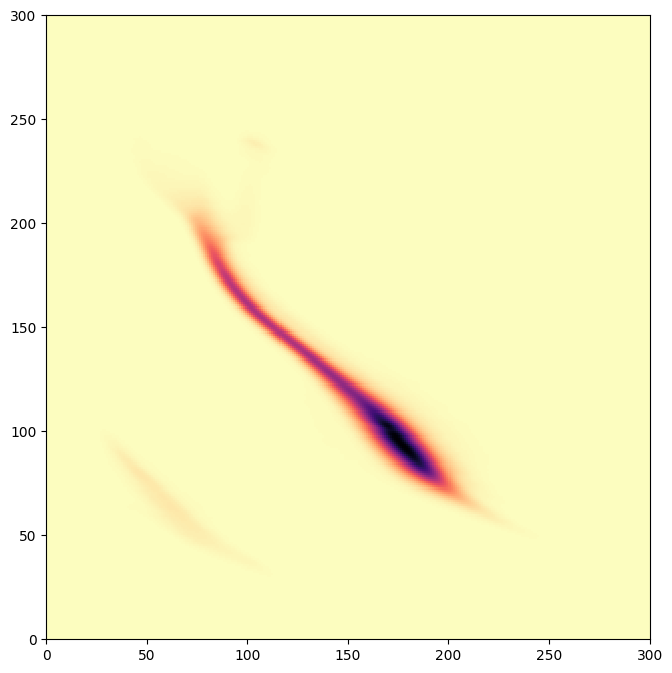

In [11]:
plt.figure(figsize=(6,6), dpi=100)
plt.pcolormesh(large_bw_kde, cmap='magma_r')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

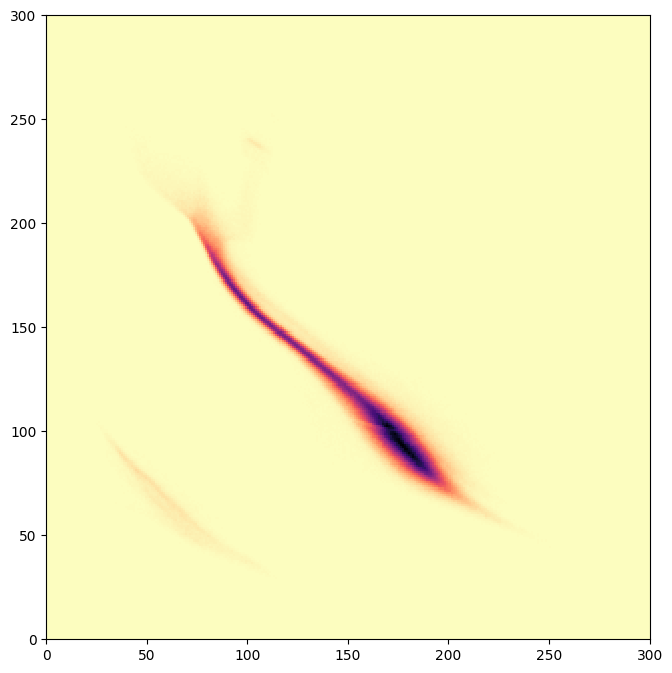

In [12]:
plt.figure(figsize=(6,6), dpi=100)
plt.pcolormesh(small_bw_kde, cmap='magma_r')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

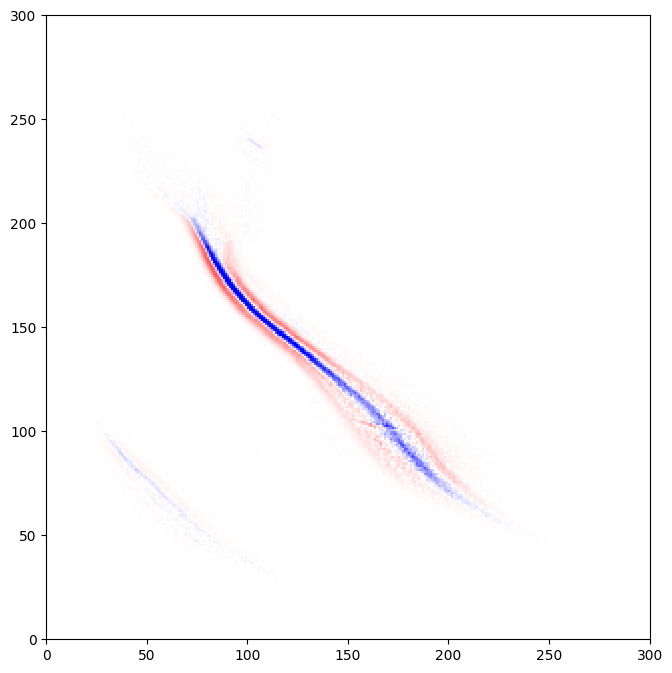

In [13]:
plt.figure(figsize=(6,6), dpi=100)
plt.pcolormesh(diff, cmap='bwr', vmin=-210, vmax=210)
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

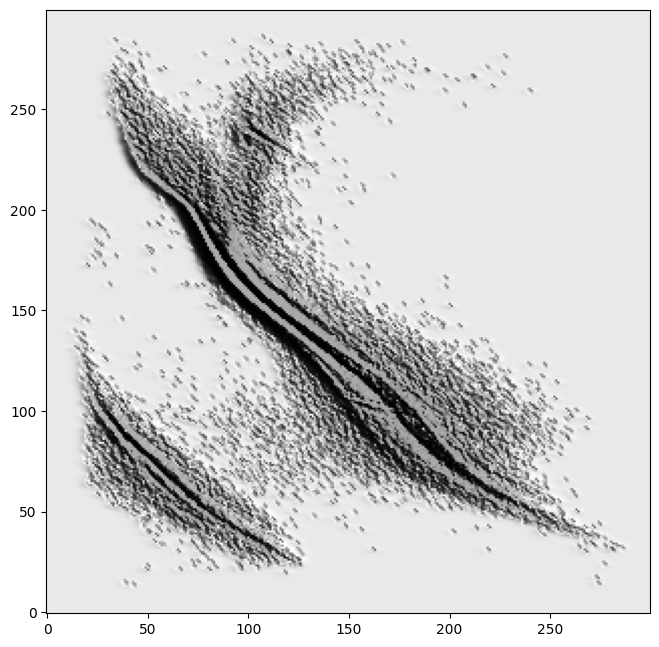

In [14]:
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(intensity, cmap='gray', origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

# Fig. 3: Normal fields

In [15]:
from pycolormap_2d import ColorMap2DSteiger

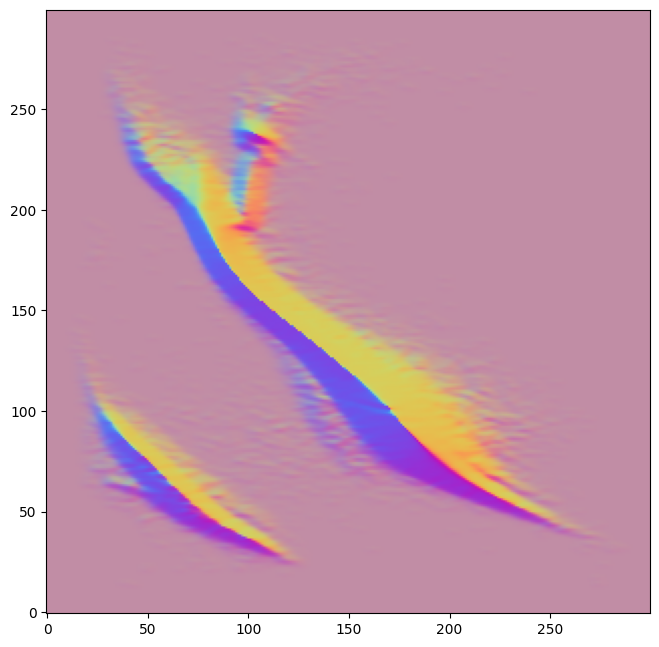

In [16]:
normal = calNormal(large_bw_kde, vert_exag=1)
normal_x, normal_y = normal[..., 0], normal[..., 1]
cmap = ColorMap2DSteiger(range_x=(1, -1),range_y=(1, -1))
vec_plot = np.zeros((*normal_x.shape, 3), dtype=np.uint8)
for i in range(normal_x.shape[0]):
    for j in range(normal_x.shape[1]):
        vec_plot[j][i] = cmap(normal_x[j][i], normal_y[j][i])

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(vec_plot, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

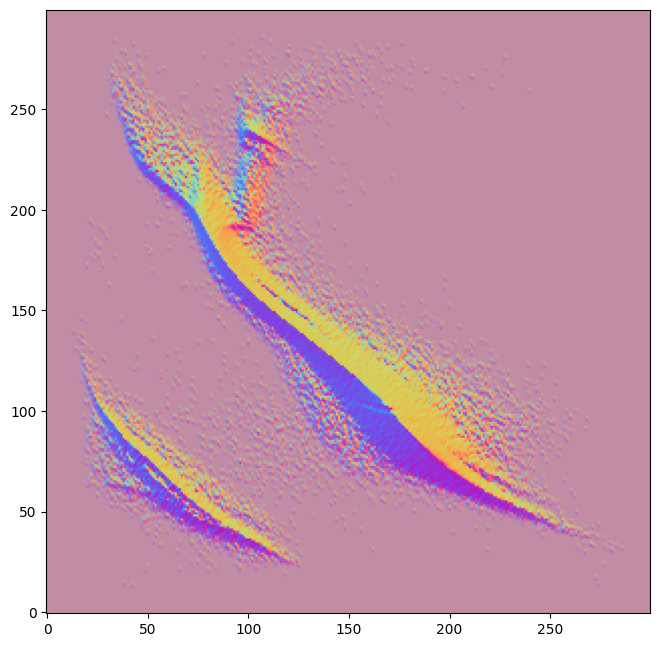

In [17]:
normal = calNormal(small_bw_kde, vert_exag=1)
normal_x, normal_y = normal[..., 0], normal[..., 1]
cmap = ColorMap2DSteiger(range_x=(1, -1),range_y=(1, -1))
vec_plot = np.zeros((*normal_x.shape, 3), dtype=np.uint8)
for i in range(normal_x.shape[0]):
    for j in range(normal_x.shape[1]):
        vec_plot[j][i] = cmap(normal_x[j][i], normal_y[j][i])

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(vec_plot, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

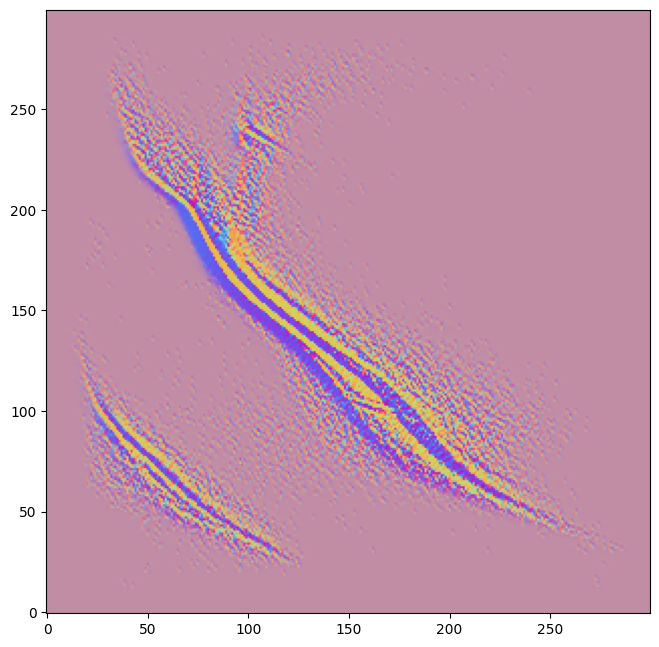

In [18]:
normal = calNormal(diff, vert_exag=1)
from pycolormap_2d import ColorMap2DSteiger
normal_x, normal_y = normal[..., 0], normal[..., 1]
cmap = ColorMap2DSteiger(range_x=(1, -1),range_y=(1, -1))
vec_plot = np.zeros((*normal_x.shape, 3), dtype=np.uint8)
for i in range(normal_x.shape[0]):
    for j in range(normal_x.shape[1]):
        vec_plot[j][i] = cmap(normal_x[j][i], normal_y[j][i])

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(vec_plot, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

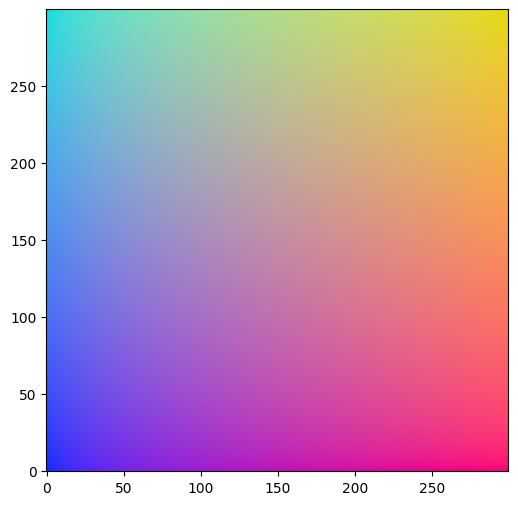

In [19]:
X,Y = np.meshgrid(np.linspace(-1,1,300), np.linspace(-1,1,300))
vec_plot = np.zeros((*X.shape, 3), dtype=np.uint8)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        vec_plot[j][i] = cmap(X[j][i], Y[j][i])
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(vec_plot, origin='lower')

# Fig. 4: Comparison of Different Eta

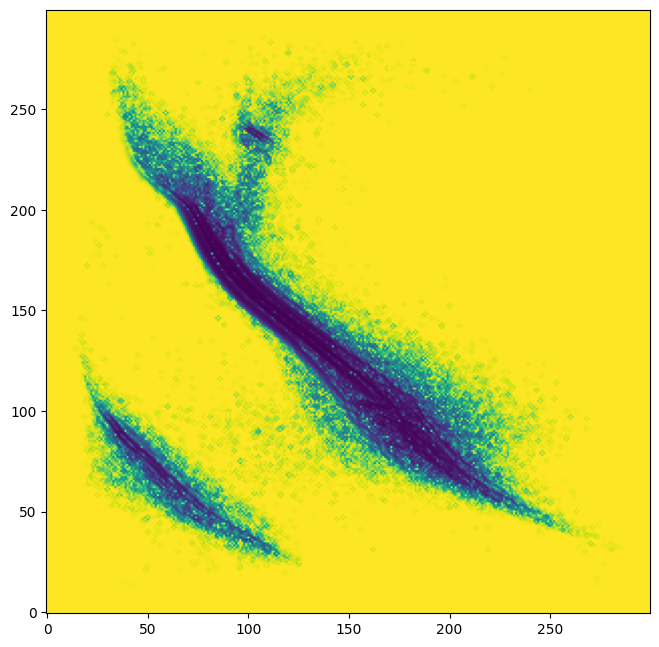

In [20]:
normal = calNormal(diff, vert_exag=1)
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(normal[...,2], origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

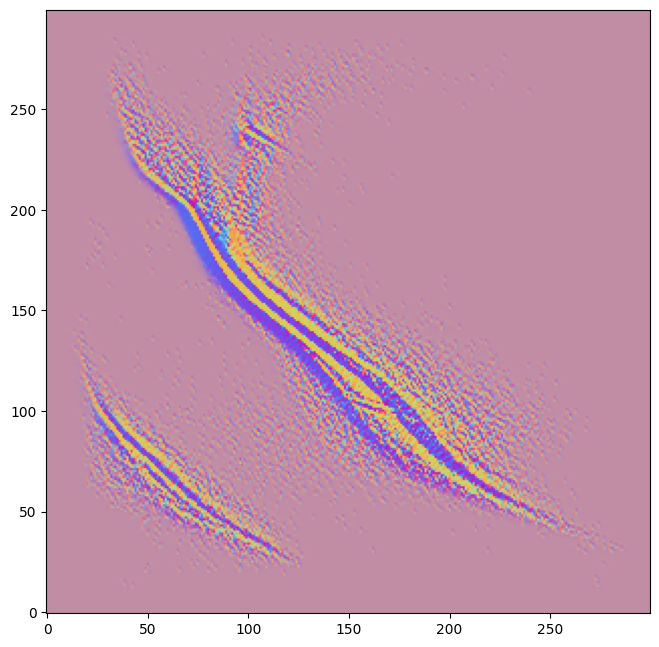

In [21]:
normal = calNormal(diff, vert_exag=1)
from pycolormap_2d import ColorMap2DSteiger
normal_x, normal_y = normal[..., 0], normal[..., 1]
cmap = ColorMap2DSteiger(range_x=(1, -1),range_y=(1, -1))
vec_plot = np.zeros((*normal_x.shape, 3), dtype=np.uint8)
for i in range(normal_x.shape[0]):
    for j in range(normal_x.shape[1]):
        vec_plot[j][i] = cmap(normal_x[j][i], normal_y[j][i])

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(vec_plot, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

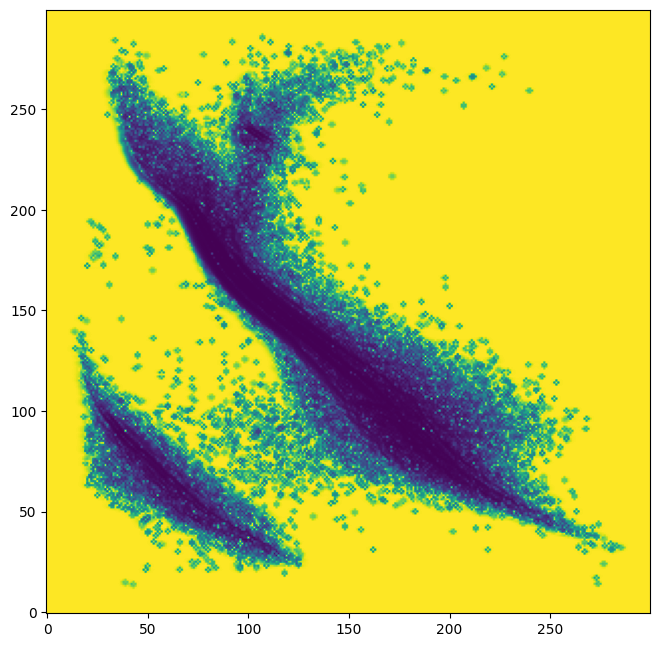

In [22]:
normal = calNormal(diff, vert_exag=5)
plt.figure(figsize=(6,6), dpi=100)
plt.imshow(normal[...,2], origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

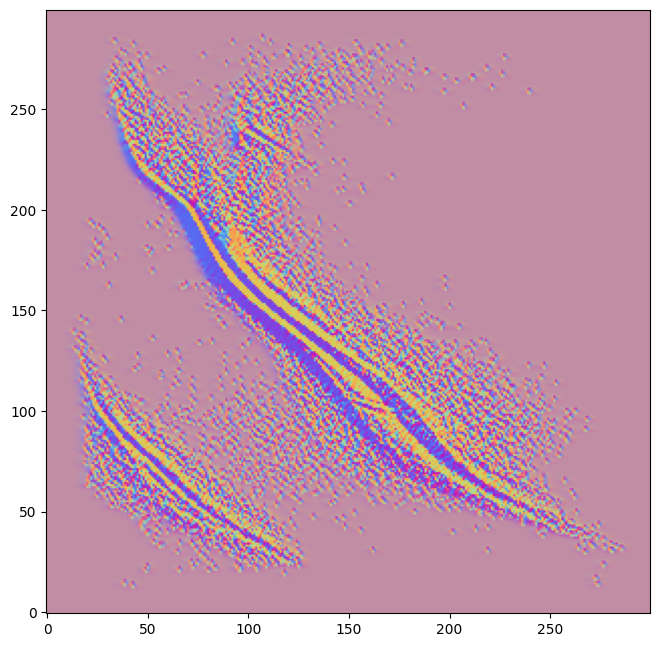

In [23]:
normal = calNormal(diff, vert_exag=5)
from pycolormap_2d import ColorMap2DSteiger
normal_x, normal_y = normal[..., 0], normal[..., 1]
cmap = ColorMap2DSteiger(range_x=(1, -1),range_y=(1, -1))
vec_plot = np.zeros((*normal_x.shape, 3), dtype=np.uint8)
for i in range(normal_x.shape[0]):
    for j in range(normal_x.shape[1]):
        vec_plot[j][i] = cmap(normal_x[j][i], normal_y[j][i])

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(vec_plot, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

# Fig. 5: Comparison of Light Directions

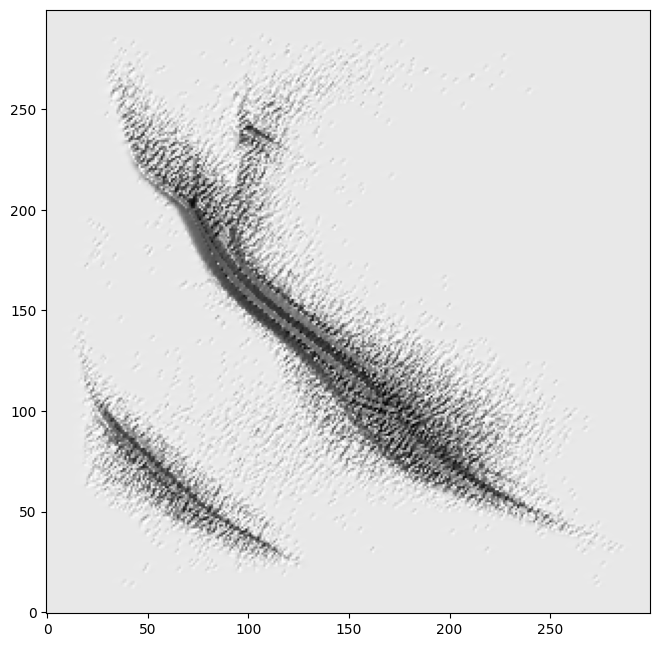

In [24]:
normal = calNormal(diff, vert_exag=1)
ld = direction(azdeg=120, altdeg=60)
intensity = normal.dot(ld)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(intensity, cmap='gray', origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

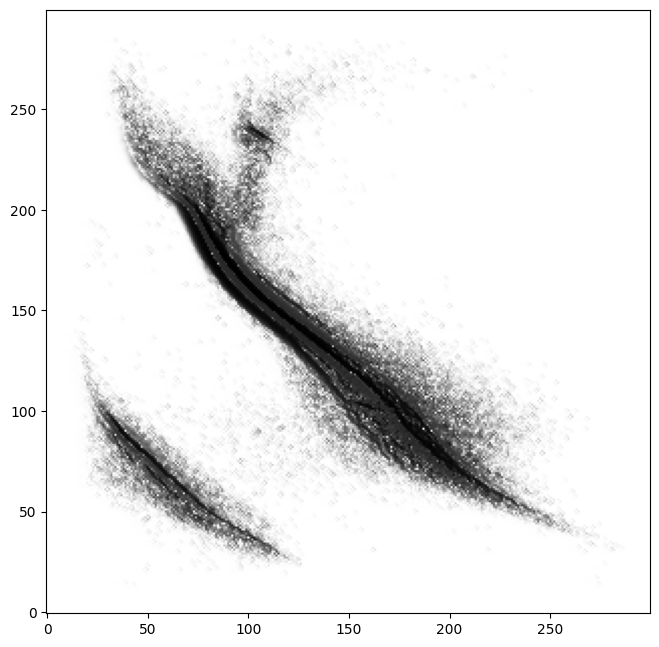

In [25]:
normal = calNormal(diff, vert_exag=1)
ld = direction(azdeg=30, altdeg=85)
intensity = normal.dot(ld)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(intensity, cmap='gray', origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

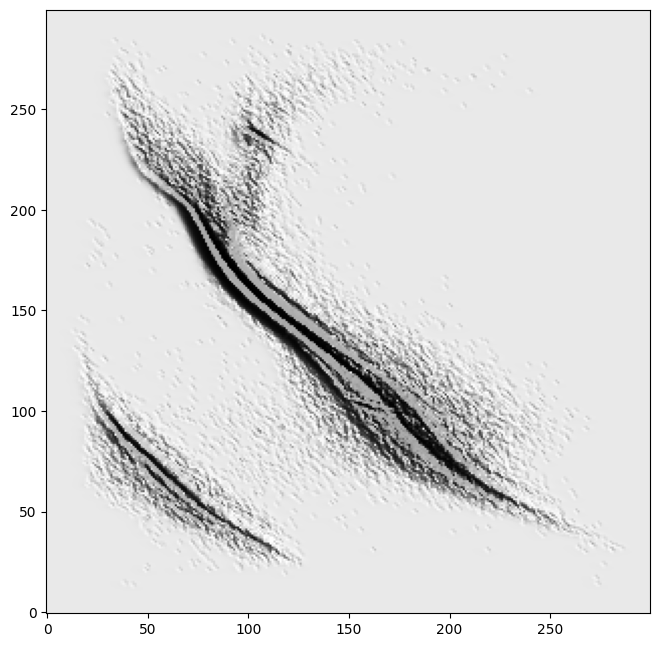

In [26]:
normal = calNormal(diff, vert_exag=1)
ld, ld2 = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(intensity, cmap='gray', origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

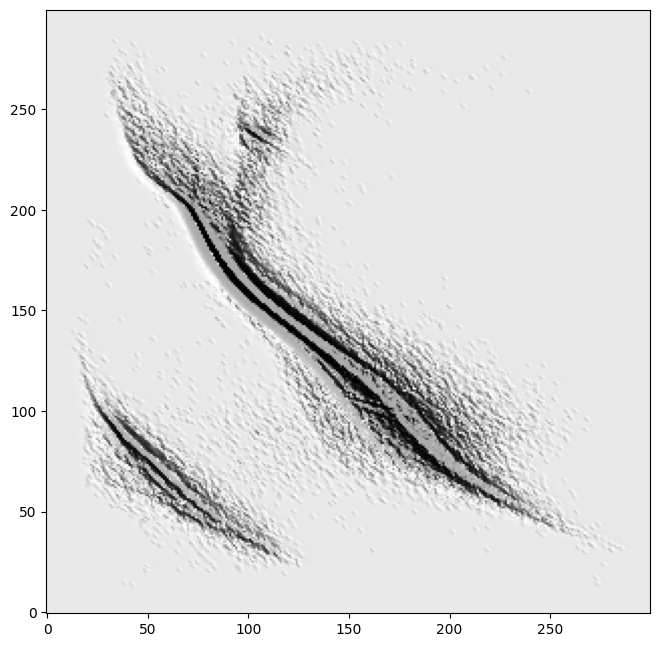

In [27]:
intensity = normal.dot(ld2)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(intensity, cmap='gray', origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

# Fig. 6: Comparison of Color Composition Methods

In [28]:
# compute the exaggerated intensity field
eta, phi = 5, -25
normal = calNormal(diff, vert_exag=eta)
ld, _ = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

# colorize the KDE field with the large bandwidth
dst = large_bw_kde
vmin, vmax = dst.min(), dst.max()
colormap = plt.cm.magma_r
norm = matplotlib.colors.Normalize(vmin, vmax)
rgb = colormap(norm(dst))

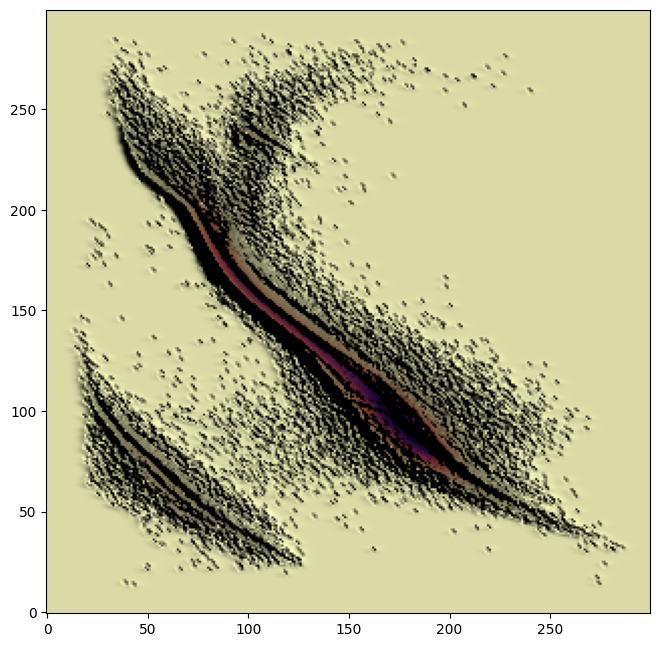

In [29]:
intensity = np.where(intensity > 0, intensity, 0)
result = blendMultiplication(rgb, intensity)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

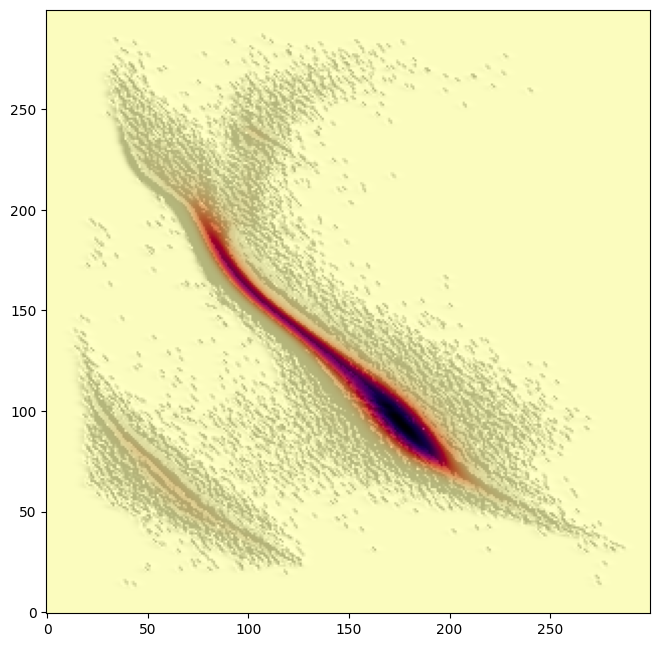

In [30]:
intensity = linear_mapping(intensity.min(), np.array([0,0,1]).dot(ld), phi, 0)(intensity)
result = blendLChannel(rgb, intensity)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

In [31]:
# compute the exaggerated intensity field
eta, phi = 5, 35
normal = calNormal(diff, vert_exag=eta)
ld, _ = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

# colorize the KDE field with the large bandwidth
dst = large_bw_kde
vmin, vmax = dst.min(), dst.max()
colormap = plt.cm.magma
norm = matplotlib.colors.Normalize(vmin, vmax)
rgb = colormap(norm(dst))

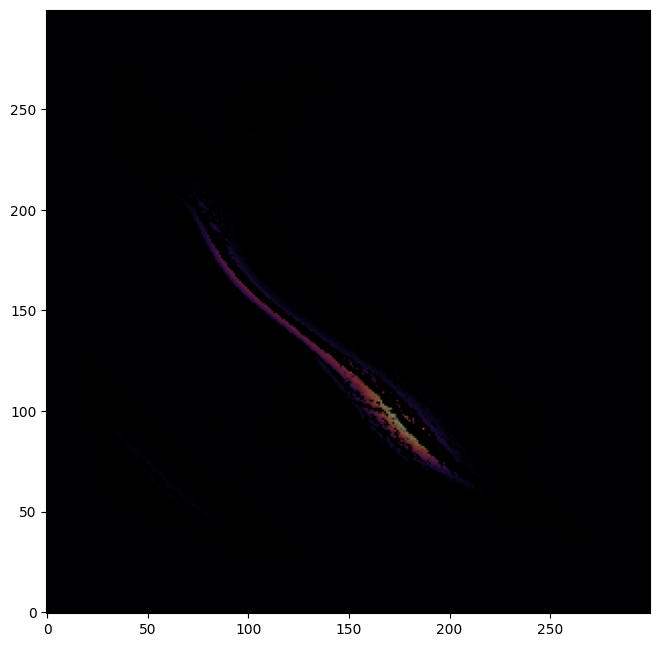

In [32]:
intensity = np.where(intensity > 0, intensity, 0)
result = blendMultiplication(rgb, intensity)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

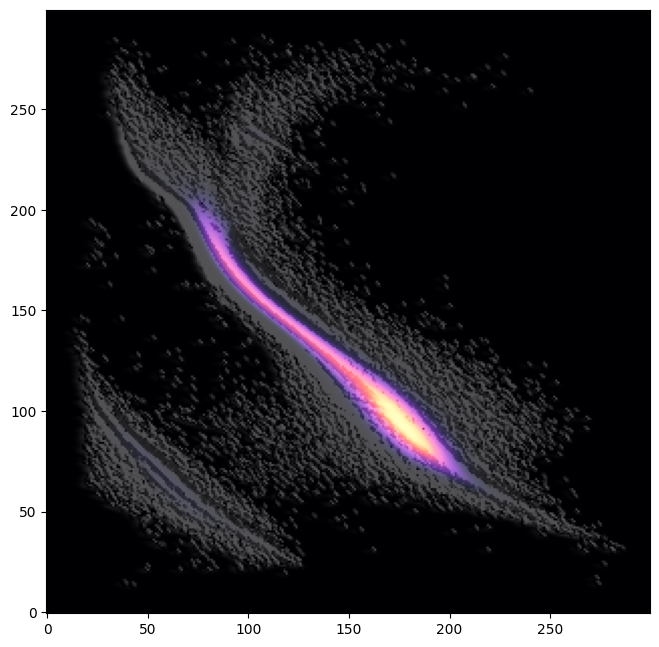

In [33]:
intensity = linear_mapping(intensity.min(), np.array([0,0,1]).dot(ld), phi, 0)(intensity)
result = blendLChannel(rgb, intensity)

plt.figure(figsize=(6,6), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

# Fig. 13: Case Study - Barcelona Accidents

In [34]:
df = pd.read_csv('./datasets/Barcelona.csv', header=None).dropna()

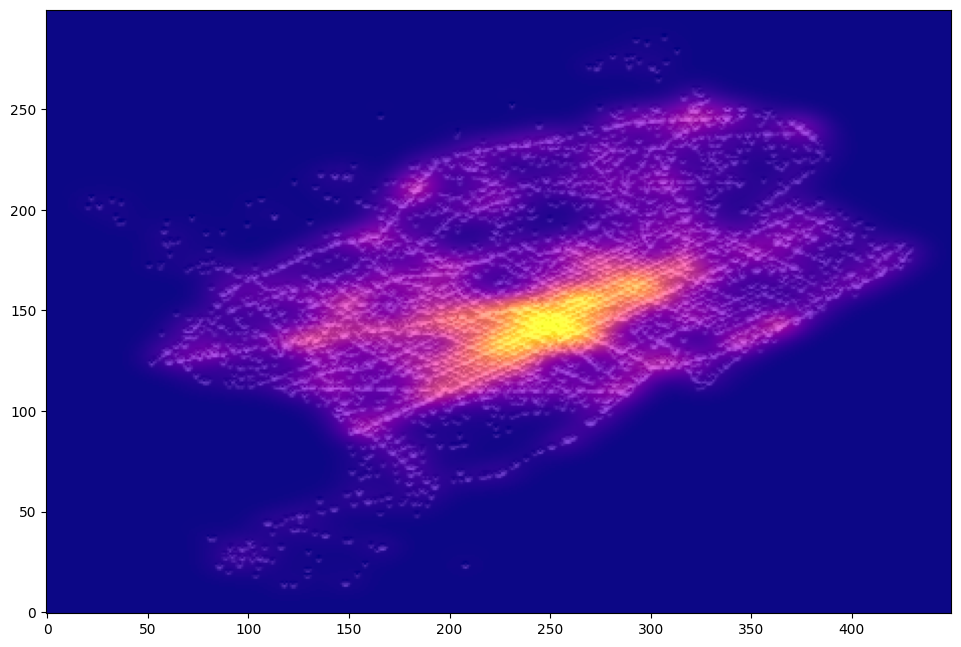

In [35]:
# compute the structure map by differencing KDE fields with large and small bandwidths
data = df[[0,1]].values
xmin, ymin = data.min(axis=0)
xmax, ymax = data.max(axis=0)
xoffset, yoffset = 0.05*np.array([xmax-xmin, ymax-ymin])
X,Y = np.mgrid[(xmin-xoffset):(xmax+xoffset):450j, (ymin-yoffset):(ymax+yoffset):300j]
grid = np.vstack([X.ravel(), Y.ravel()]).T

bw1=0.0027 #Barcelona_accident
data_scaled = data / np.array([bw1])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw1]))
points = points/points.sum()*data.shape[0]
large_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
bw2 = 2e-4
data_scaled = data / np.array([bw2])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw2]))
points = points/points.sum()*data.shape[0]
small_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
diff = large_bw_kde - small_bw_kde

# colorize the KDE field with the large bandwidth
dst = large_bw_kde
vmin, vmax = dst.min(), dst.max()
colormap = plt.cm.plasma
norm = matplotlib.colors.Normalize(vmin, vmax)
rgb = colormap(norm(dst))

# compute the exaggerated intensity field
eta, phi = 5, 25
normal = calNormal(diff, vert_exag=eta)
ld,_ = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

# Luminance-Only Color Composition
intensity = linear_mapping(intensity.min(), np.array([0,0,1]).dot(ld), phi, 0)(intensity)
result = blendLChannel(rgb, intensity)

plt.figure(figsize=(9,6), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

# Fig. 14: Case Study - UK Road Safety

In [36]:
df = pd.read_csv('./datasets/uk_traffic_accident.csv', header=None).dropna()

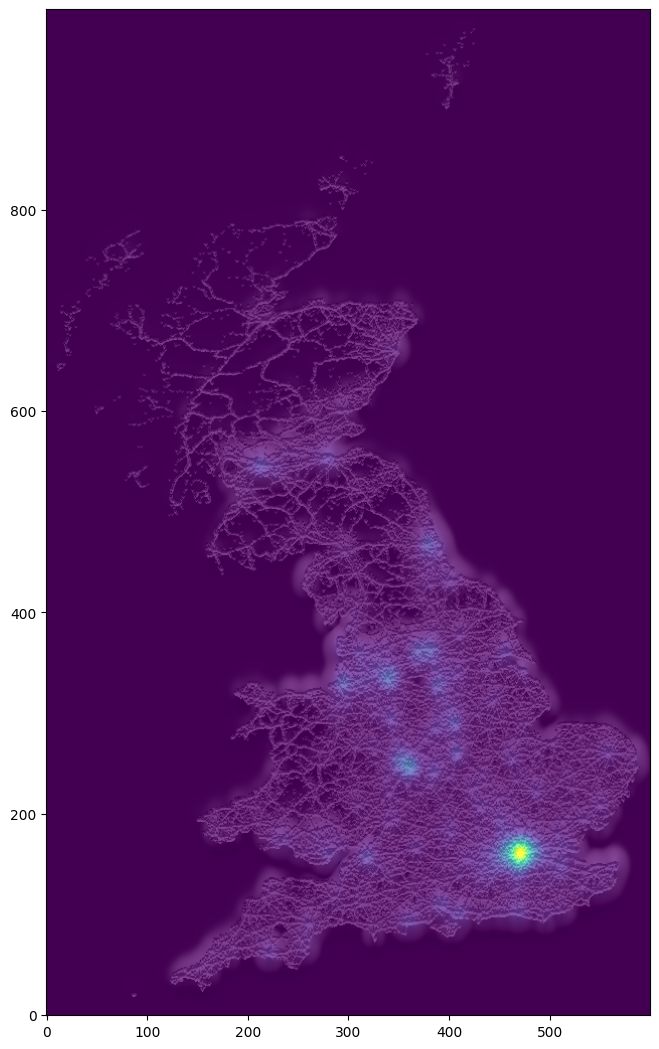

In [39]:
# compute the structure map by differencing KDE fields with large and small bandwidths
data = df[[0,1]].values
xmin, ymin = data.min(axis=0)
xmax, ymax = data.max(axis=0)
xoffset, yoffset = 0.02*np.array([xmax-xmin, ymax-ymin])
X,Y = np.mgrid[(xmin-xoffset):(xmax+xoffset):600j, (ymin-yoffset):(ymax+yoffset):1000j]
grid = np.vstack([X.ravel(), Y.ravel()]).T

bw1 = min(silvermans_rule(data[:, [0]]), silvermans_rule(data[:, [1]]))
data_scaled = data / np.array([bw1])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw1]))
points = points/points.sum()*data.shape[0]
large_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
bw2 = min([1/X.shape[0], 1/X.shape[1]])
data_scaled = data / np.array([bw2])
points = KDEpy.FFTKDE(bw=1).fit(data_scaled).evaluate(grid/np.array([bw2]))
points = points/points.sum()*data.shape[0]
small_bw_kde = points.reshape(X.shape[0], X.shape[1]).T
diff = large_bw_kde - small_bw_kde

# colorize the KDE field with the large bandwidth
dst = large_bw_kde
vmin, vmax = dst.min(), dst.max()
colormap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin, vmax)
rgb = colormap(norm(dst))

# compute the exaggerated intensity field
eta, phi = 5, 25
normal = calNormal(diff, vert_exag=eta)
ld,_ = setupLightDirection3(normal[~np.isclose(small_bw_kde, 0)])
intensity = normal.dot(ld)

# Luminance-Only Color Composition
intensity = linear_mapping(intensity.min(), np.array([0,0,1]).dot(ld), phi, 0)(intensity)
result = blendLChannel(rgb, intensity)

plt.figure(figsize=(6,10), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)

-2.4526816621273895 25.0
-2.4526816621273895 25.0
-2.4626970724143535 25.0


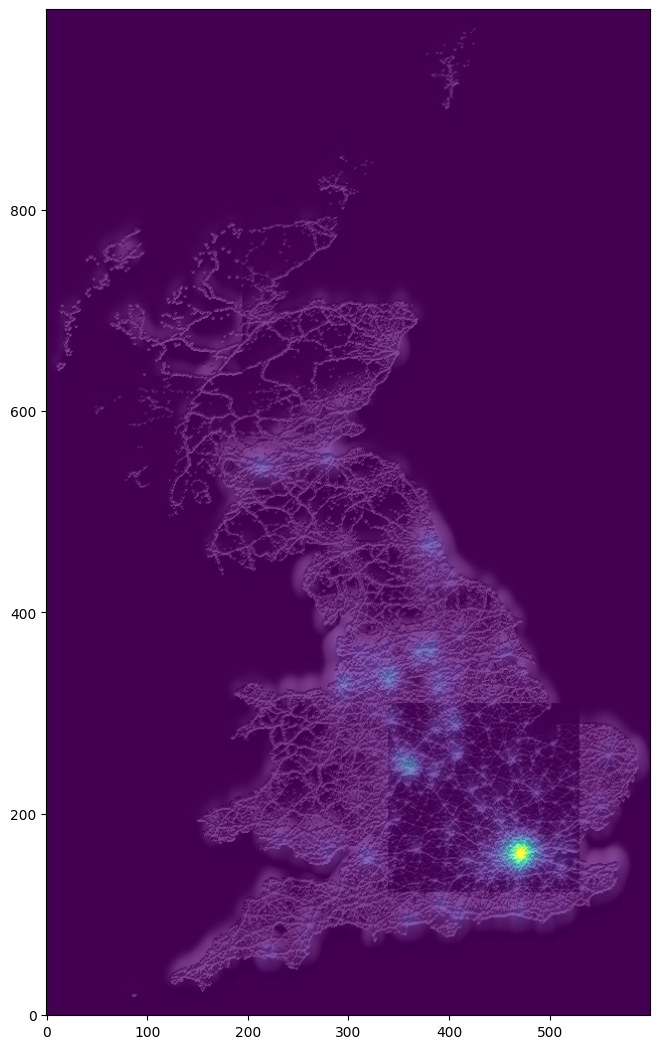

In [40]:
normal = calNormal(diff, vert_exag=5)
ld, _ = setupLightDirection3(normal[np.isclose(small_bw_kde, 0)])
intensity = calIntensity(normal, ld)
intensity = (25/intensity.min())*intensity
print(intensity.min(), intensity.max())
normal = calNormal(diff, vert_exag=50)
ld, _ = setupLightDirection3(normal[np.isclose(small_bw_kde, 0)])
local_intensity = calIntensity(normal, ld)
local_intensity = (25/local_intensity.min())*local_intensity
intensity[635:815, 5:195] = local_intensity[635:815, 5:195] #UK_road_safety purple
print(intensity.min(), intensity.max())
normal = calNormal(diff, vert_exag=0.2)
ld, _ = setupLightDirection3(normal[np.isclose(small_bw_kde, 0)])
local_intensity = calIntensity(normal, ld)
local_intensity = (25/local_intensity.min())*local_intensity
intensity[122:310, 340:530] = local_intensity[122:310, 340:530] #UK_road_safety blue
print(intensity.min(), intensity.max())
result = blendLChannel(rgb, intensity)

plt.figure(figsize=(6,10), dpi=100)
plt.imshow(result, origin='lower')
plt.subplots_adjust(top = 1.02, bottom = -0.02, right = 1.003, left = -0.003, hspace = 0, wspace = 0)
plt.margins(0,0)